### ELV Assignment 1
[Reference Paper](https://www.pnas.org/doi/10.1073/pnas.1802705116)  
[Reference video 1](https://youtu.be/9GkxEEqEGhg?si=eSbcXl5bgqmUorJJ)  
[Reference video 2](https://www.youtube.com/watch?v=hEGGa8y5_wM)  
[pythonspeed](https://pythonspeed.com/)


![Fig 2 from paper](./figures/fig2.png)

X,y computed
success, test train split done
Alpha=0.2, Error=1.6000
Alpha=0.4, Error=1.4000
Alpha=0.6, Error=1.0000
Alpha=0.8, Error=1.0000
Alpha=1.0, Error=0.6000
Alpha=1.2, Error=0.8000
Alpha=1.4, Error=0.6000
Alpha=1.6, Error=0.4000
Alpha=1.8, Error=0.4000
Alpha=2.0, Error=0.4000
X,y computed
success, test train split done
Alpha=0.2, Error=1.6000
Alpha=0.4, Error=1.0000
Alpha=0.6, Error=1.2000
Alpha=0.8, Error=1.6000
Alpha=1.0, Error=1.2000
Alpha=1.2, Error=1.2000
Alpha=1.4, Error=0.6000
Alpha=1.6, Error=0.4000
Alpha=1.8, Error=0.4000
Alpha=2.0, Error=0.4000


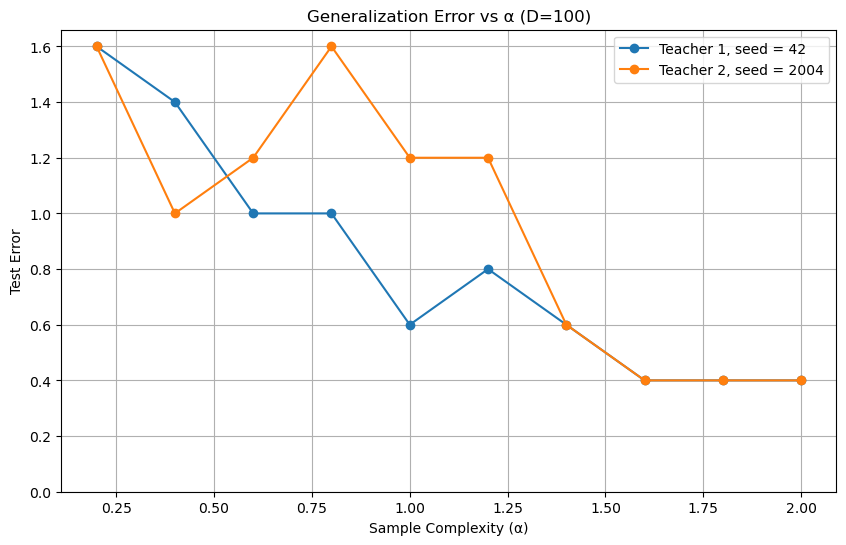

Plot saved as ./figures/generalization_error_D100_combined.png


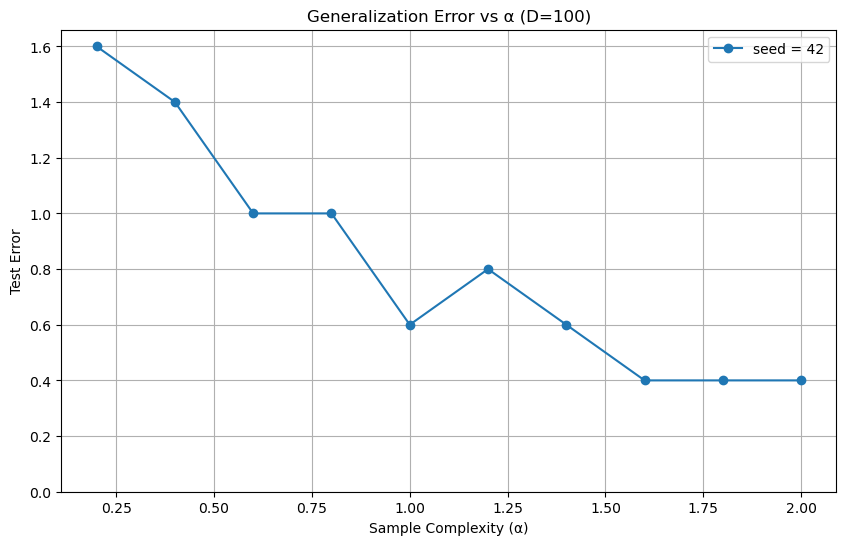

Plot saved as ./figures/generalization_error_D100_teacher 1.png


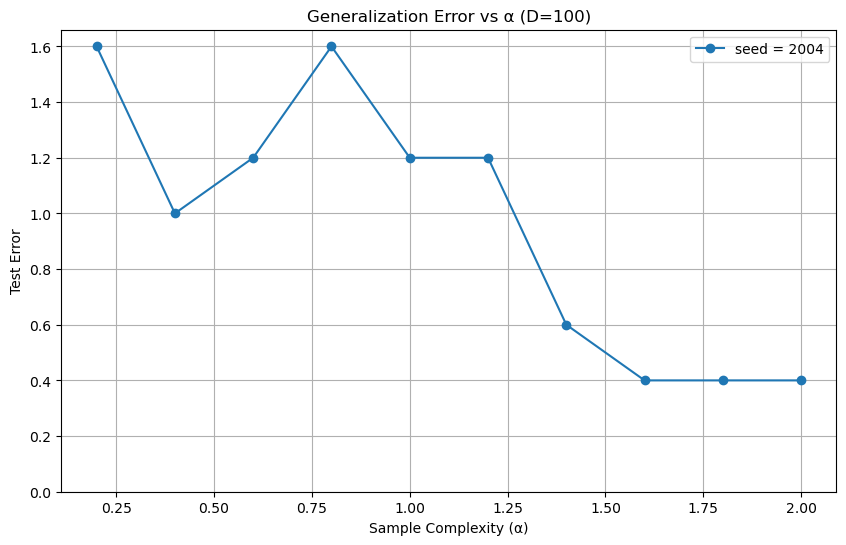

Plot saved as ./figures/generalization_error_D100_teacher 2.png


In [1]:
'''
Below is a naive implementaiton of the assignment (it fails for large D, primarily due to memory issues)
'''

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import gc

def run_experiment(D=10000, teacher_seed=42):
    # Step 1: Generate teacher model (with random binary weights)
    # we do some things to be able to generate data for large D without memory issues
    np.random.seed(teacher_seed) 
    w_teacher = np.random.choice([1, -1], size=D) # arr of size D with +-1 

    # Step 2: Generate dataset
    N_total = int(2.2 * D)  # 2D (train) + 0.2D (test)
    X = np.random.randn(N_total, D)  

    y = np.sign(X@(w_teacher))  # labels {+1,-1} 
    y[y == 0] = 1  # Replace any 0s with 1
    del w_teacher
    gc.collect()
    print('X,y computed')
    # Split dataset into test and train
    X_train, X_test = X[:2*D], X[2*D:]
    y_train, y_test = y[:2*D], y[2*D:]
    del X, y
    gc.collect() 
    # Define range of α values
    print("success, test train split done")
    alphas = np.arange(0.2, 2.2, 0.2) # [0.2,0.4...2]
    test_errors = []

    # Precompute hyperparameter grid for Logistic Regression
    Cs = np.logspace(-4, 6, 15) 

    for alpha in alphas:
        n = int(alpha * D)
        X_subset = X_train.view()[:n] # prevent array copying
        y_subset = y_train.view()[:n]

        # Train Logistic Regression with cross-validation
        model = LogisticRegressionCV(
            Cs=Cs, cv=4, penalty='l2', solver='saga',
            max_iter=100000, tol=1e-3, random_state=teacher_seed, n_jobs=-1
        )
        model.fit(X_subset, y_subset)
        y_pred = model.predict(X_test)

        # Compute classification error (misclassification rate)
        test_error = np.mean(np.square(y_test-y_pred)) 
        test_errors.append(test_error)

        print(f"Alpha={alpha:.1f}, Error={test_error:.4f}")

    return alphas, test_errors

def plot_results(alphas, errors_list, labels, D,name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Test Error')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0,)
    plt.legend()

    # Save figure 
    filename = f'./figures/generalization_error_D{D}_{name}.png'
    plt.savefig(filename)
    plt.show()

    print(f"Plot saved as {filename}")

# Experiment: Run with different teacher seeds
# This will fail for large D (especially due to memory issues) -> fix using batches, torch blah blah
D = int(1e2) # dimensionality   
teacher_seed1,teacher_seed2 = 42,2004

alphas, errors1 = run_experiment(D=D, teacher_seed=teacher_seed1)
_, errors2 = run_experiment(D=D, teacher_seed=teacher_seed2)
plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D,name='combined')
plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D,name = 'teacher 1')
plot_results(alphas, [errors2], [f'seed = {teacher_seed2}'], D=D,name = 'teacher 2')

In [13]:
import jax
import seaborn as sns
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import psutil
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import multiprocessing

def print_file_info(file_path):
    if os.path.isfile(file_path):
        file_size_bytes = os.path.getsize(file_path)
        file_size_gb = file_size_bytes / (1024 ** 2)
        print(f"File: {file_path}")
        print(f"Size: ({file_size_gb:.4f} MB)")
    else:
        print(f"File not found: {file_path}")

def generate_data(D=10000, teacher_seed=42, alpha_min=0.2, alpha_max=2):
    try:
        print("Initializing data generation...")
        key = random.PRNGKey(teacher_seed)
        w_teacher = 2 * random.bernoulli(key, 0.5, shape=(D,)) - 1

        N_total = int((alpha_max + alpha_min) * D)
        print('Creating memory-mapped data...')
        X = np.memmap('./X_data.dat', dtype='float16', mode='w+', shape=(N_total, D))
        y = np.memmap('./y_data.dat', dtype='float16', mode='w+', shape=(N_total,))

        batch_size = min(D,1e4)
        num_batches = (N_total + batch_size - 1) // batch_size
        key = random.split(key, num_batches)

        @jit
        def process_batch(subkey, w_teacher):
            X_batch = (random.normal(subkey, (batch_size, D))).astype(jnp.float16)
            y_batch = jnp.sign(X_batch @ w_teacher).astype(jnp.float16)
            y_batch = jnp.where(y_batch == 0, 1, y_batch)
            return X_batch, y_batch

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, N_total)
            current_batch_size = end - start
            print(f"Processing batch {start}-{end}")
            X_batch, y_batch = process_batch(key[i], w_teacher)
            X[start:end] = np.asarray(X_batch[:current_batch_size])
            y[start:end] = np.asarray(y_batch[:current_batch_size])

        del w_teacher, key, X_batch, y_batch
        gc.collect()
        print("Data generation completed.")

    except MemoryError:
        print("MemoryError: Reduce D or batch size.")
        exit()

def plot_results(alphas, errors_list, labels, D, name):
    plt.figure(figsize=(10, 6))
    for errors, label in zip(errors_list, labels):
        plt.plot(alphas, errors, 'o-', label=label)
    plt.xlabel('Sample Complexity (α)')
    plt.ylabel('Generalization Error (MSE)')
    plt.title(f'Generalization Error vs α (D={D})')
    plt.grid(True)
    plt.ylim(0, )
    plt.legend()

    os.makedirs('./figures', exist_ok=True)
    filename = f'./figures/generalization_error_D{D}_{name}.png'
    plt.savefig(filename)

    plt.show()
    print(f"Plot saved as {filename}")

In [16]:
'''
Optimised version, using JAX, parallelisation and batching. Can handle large D.
'''

import numpy as np
import gc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
from joblib import parallel_backend
from tqdm import tqdm
parallel_backend("loky")

os.environ["MallocStackLogging"] = "0"
os.environ["MallocStackLoggingNoCompact"] = "1"
os.environ["DYLD_INSERT_LIBRARIES"] = ""
multiprocessing.set_start_method("spawn", force=True)

def calculate_cross_entropy_loss_batched(y_true, y_pred, batch_size=1024):
    epsilon = 1e-15
    total_loss = 0.0
    total_samples = len(y_true)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_true = y_true[i:batch_end]
        batch_pred = y_pred[i:batch_end]
        
        batch_pred = np.clip(batch_pred, epsilon, 1 - epsilon)
        batch_loss = -(batch_true * np.log(batch_pred) + (1 - batch_true) * np.log(1 - batch_pred))
        total_loss += np.sum(batch_loss)
    
    return total_loss / total_samples if total_samples > 0 else float('inf')

def batch_predict_proba(model, X, batch_size=1024):
    total_samples = len(X)
    probas = np.zeros(total_samples)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        probas[i:batch_end] = model.predict_proba(batch)[:, 1]
    return probas

def batch_predict(model, X, batch_size):
    total_samples = len(X)
    predictions = np.zeros(total_samples, dtype=int)
    
    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch = X[i:batch_end]
        predictions[i:batch_end] = model.predict(batch)
    
    return predictions

def train_model_for_alpha(alpha, D, teacher_seed, X_train, y_train, X_test, y_test, kf, reg_values, batch_size, num_epochs, n_splits):
    n_samples = int(alpha * D)
    X_subset, y_subset = X_train[:n_samples], y_train[:n_samples]
    
    best_model = None
    best_loss = float('inf')
    best_alpha_value = None
    
    for reg_alpha in tqdm(reg_values, desc=f"Alpha {alpha:.3g}"):
        avg_loss = 0
        model = SGDClassifier(
            loss='log_loss',
            penalty='l2',
            alpha=reg_alpha,
            max_iter=1,
            tol=None,
            random_state=teacher_seed,
            warm_start=True,
            n_jobs=4,
            learning_rate='optimal'
        )
        
        for train_idx, val_idx in kf.split(X_subset):
            for epoch in range(num_epochs):
                for batch_start in range(0, len(train_idx), batch_size):
                    batch_end = min(batch_start + batch_size, len(train_idx))
                    batch_train_idx = train_idx[batch_start:batch_end]
                    
                    if len(batch_train_idx) > 0:
                        model.partial_fit(
                            X_subset[batch_train_idx],
                            y_subset[batch_train_idx],
                            classes=[-1, 1]
                        )
            
            prob_pred = batch_predict_proba(model, X_subset[val_idx], batch_size=batch_size)
            val_labels_binary = (y_subset[val_idx] + 1) // 2
            loss = calculate_cross_entropy_loss_batched(val_labels_binary, prob_pred, batch_size=batch_size)
            avg_loss += loss / n_splits
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_alpha_value = reg_alpha
            best_model = model
    
    y_test_pred = batch_predict(best_model, X_test, batch_size=batch_size)
    test_error = np.mean((y_test - y_test_pred) ** 2)

    return alpha, best_alpha_value, test_error

def optimized_training(D, teacher_seed, alpha_max=2, alpha_min=0.2, alpha_step=0.2, 
                        n_splits=3, batch_size=4096, num_epochs=5):
    N_total = int((alpha_max + alpha_min) * D)
    X = np.memmap('./X_data.dat', dtype='float16', mode='r', shape=(N_total, D))
    y = np.memmap('./y_data.dat', dtype='float16', mode='r', shape=(N_total,))
    
    train_size = int(alpha_max * D)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    alphas = np.arange(alpha_min, alpha_max + alpha_step, alpha_step)
    reg_values = np.logspace(-2.5, 0, 10)
    kf = KFold(n_splits=n_splits, shuffle=False)
    
    results = Parallel(n_jobs=2)(
        delayed(train_model_for_alpha)(alpha, D, teacher_seed, X_train, y_train, X_test, y_test, kf, reg_values, batch_size, num_epochs, n_splits)
        for alpha in tqdm(alphas, desc="Training Progress")
    )
    
    alphas, best_reg_values, test_errors = zip(*results)
    
    for alpha, best_reg, error in results:
        print(f"Alpha: {alpha:.3g} | Best regularization alpha: {best_reg:.4g} | Test Error: {error:.3g}")
    
    return alphas, test_errors


In [18]:
D = int(1e3)
alpha_min,alpha_max,alpha_step = 0.2,2,0.2
teacher_seed1, teacher_seed2 = 24,72

two_teachers = False 

generate_data(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min)

Initializing data generation...
Creating memory-mapped data...
Processing batch 0-1000
Processing batch 1000-2000
Processing batch 2000-2200
Data generation completed.


File: ./X_data.dat
Size: (4.1962 MB)
File: ./y_data.dat
Size: (0.0042 MB)


Alpha 2:  90%|█████████ | 9/10 [00:01<00:00,  8.78it/s]

Alpha: 0.2 | Best regularization alpha: 0.2783 | Test Error: 1.56
Alpha: 0.4 | Best regularization alpha: 0.2783 | Test Error: 1.38
Alpha: 0.6 | Best regularization alpha: 0.07743 | Test Error: 1.38
Alpha: 0.8 | Best regularization alpha: 0.07743 | Test Error: 1.18
Alpha: 1 | Best regularization alpha: 0.07743 | Test Error: 1
Alpha: 1.2 | Best regularization alpha: 0.07743 | Test Error: 1.04
Alpha: 1.4 | Best regularization alpha: 0.07743 | Test Error: 0.92
Alpha: 1.6 | Best regularization alpha: 0.04084 | Test Error: 0.98
Alpha: 1.8 | Best regularization alpha: 0.04084 | Test Error: 0.84
Alpha: 2 | Best regularization alpha: 0.04084 | Test Error: 0.8


Alpha 2: 100%|██████████| 10/10 [00:01<00:00,  8.45it/s]


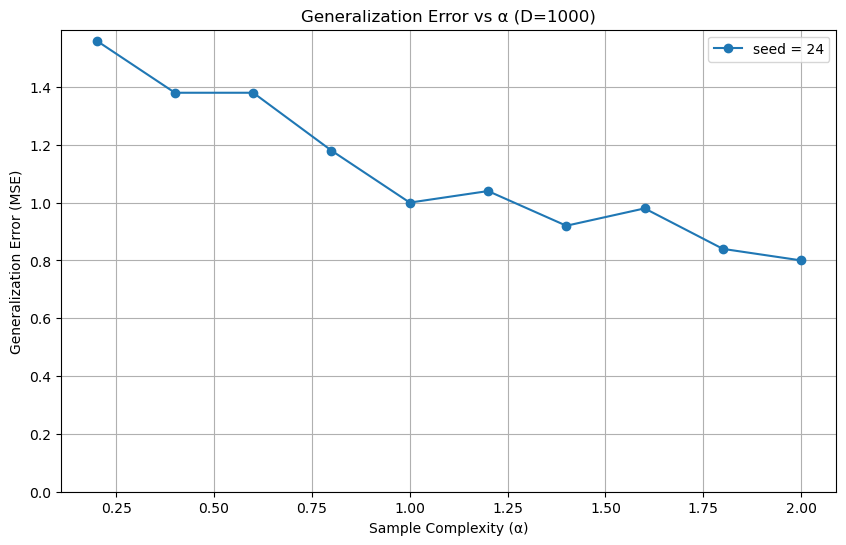

Plot saved as ./figures/generalization_error_D1000_plot.png


In [19]:
print_file_info('./X_data.dat')
print_file_info('./y_data.dat')
        
alpha_min,alpha_max,alpha_step = 0.2,2,0.2
alphas, errors1 = optimized_training(D=D, teacher_seed=teacher_seed1,alpha_max=alpha_max,alpha_min=alpha_min,alpha_step=alpha_step,batch_size=int(5e3))

if(two_teachers):
    generate_data(D=D, teacher_seed=teacher_seed2)
    _, errors2 = optimized_training(D=D, teacher_seed=teacher_seed2,alpha_max=alpha_max,alpha_min=alpha_min,alpha_step=alpha_step,batch_size=int(5e3))

    plot_results(alphas, [errors1, errors2], [f'Teacher 1, seed = {teacher_seed1}', f'Teacher 2, seed = {teacher_seed2}'], D=D, name='combined')
    plot_results(alphas, [errors1], [f'Teacher 1, seed = {teacher_seed1}'], D=D, name='teacher 1')
    plot_results(alphas, [errors2], [f'Teacher 2, seed = {teacher_seed2}'], D=D, name='teacher 2')
else:
    plot_results(alphas, [errors1], [f'seed = {teacher_seed1}'], D=D, name='plot')

os.remove('X_data.dat')
os.remove('y_data.dat')